In [1]:
SparkContext

pyspark.context.SparkContext

In [2]:
sc.master

'local[*]'

In [3]:
import time

from pyspark.sql import SparkSession
from sentiment_analysis.config import logger
from sentiment_analysis.utils import delete_local_file, run_command
from sentiment_analysis.load import load_amazon_reviews, load_model
import sentiment_analysis.process as process
import sentiment_analysis.preprocess as preprocess
import matplotlib.pyplot as plt


In [4]:
def merge_results_csv_in_hdfs(read_hdfs_path, write_hdfs_path, csv_file_name):
    logger.info(f"WRITING ANALYSIS SUMMARY OUTPUT {csv_file_name} TO HDFS...")
    final_path = f"{write_hdfs_path}/{csv_file_name}.csv"
    temp_csv_path = "/tmp/merged_results.csv"
    # Merge csv files from hdfs and save them locally
    merge_command = [
        "/home/almalinux/hadoop-3.4.0/bin/hdfs",
        "dfs",
        "-getmerge",
        f"{read_hdfs_path}/part-*.csv",
        temp_csv_path,
    ]
    run_command(merge_command)

    # Upload the merged csv to hdfs
    upload_command = [
        "/home/almalinux/hadoop-3.4.0/bin/hdfs",
        "dfs",
        "-put",
        "-f",
        temp_csv_path,
        final_path,
    ]
    run_command(upload_command)
    # Remove the local merged file
    delete_local_file(temp_csv_path)


In [5]:
input_path, output_path = "/Subscription_Boxes.jsonl", "/analysis_outputs"
# Initialize Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()
# Load the dataset
reviews_df = load_amazon_reviews(spark, input_path, 0.1)
# Count total reviews
total_reviews = reviews_df.count()
logger.info(f"Starting to handle all {total_reviews:,} reviews")
# Load model and tokenizer
tokenizer, model = load_model()
# Broadcast model and tokenizer to all workers
if process.bc_model is None:
    logger.info("Broadcasting model and tokenizer to all workers")
    process.bc_tokenizer = spark.sparkContext.broadcast(tokenizer)
    process.bc_model = spark.sparkContext.broadcast(model)

25/04/12 11:44:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
2025-04-12 11:44:45,722 - INFO - Starting to handle all 1,686 reviews           
2025-04-12 11:44:45,725 - INFO - Loading BERTweet model and tokenizer...
2025-04-12 11:44:48,431 - INFO - Broadcasting model and tokenizer to all workers


In [6]:
# Repartition the DataFrame for optimal processing
target_partition_size_mb = 128
reviews_df = preprocess.repartition_dataset(
    spark, input_path, reviews_df, target_partition_size_mb
)
# Preprocess the reviews
logger.info("Starting to preprocess reviews...")
start_time = time.time()
reviews_df = preprocess.preprocess_reviews(
    reviews_df, text_column="text", output_column="preprocessed_text"
)
end_time = time.time()
logger.info(
    f"Done preprocessing all reviews in {end_time - start_time:.2f} seconds"
)
# Process reviews for sentiment analysis
logger.info("Starting to process reviews for sentiment analysis...")
start_time = time.time()
sentiment_analysis_results_df = process.process_reviews(
    reviews_df=reviews_df,
    output_path=output_path,
    review_text_column="preprocessed_text",
)
end_time = time.time()
logger.info(f"Done processing all reviews in {end_time - start_time:.2f} seconds")
# Combine results into a single csv file
logger.info("Merging results into a single CSV file...")
merge_start_time = time.time()
merge_results_csv_in_hdfs(
    output_path, "/summary_outputs", "sentiment_analysis_results"
)
merge_end_time = time.time()
logger.info(
    f"Done merging results in {merge_end_time - merge_start_time:.2f} seconds"
)
# # Clean up temporary files
# logger.info("Cleaning up temporary files...")
# # Add explicit unpersist for cached DataFrames
# reviews_df.unpersist()
# sentiment_analysis_results_df.unpresist()
# # Clear broadcasted variables when done
# process.bc_tokenizer.unpersist()
# process.bc_model.unpersist()
# # Stop Spark session
# spark.stop()

2025-04-12 11:44:52,829 - INFO - Repartitioning DataFrame for optimal processing...
2025-04-12 11:44:52,866 - INFO - Input file size: 8.54 MB
2025-04-12 11:44:52,870 - INFO - Repartitioning DataFrame into 16 partitions based on 8.54MB file size and 128MB target partition size...
2025-04-12 11:44:53,265 - INFO - Repartitioned DataFrame into 16 partitions.
2025-04-12 11:44:53,267 - INFO - Starting to preprocess reviews...
2025-04-12 11:44:53,269 - INFO - Starting review text preprocessing...
2025-04-12 11:44:53,756 - INFO - Original review count: 1,686
2025-04-12 11:44:56,129 - INFO - Preprocessing complete: 1,686 reviews retained, 0 filtered out
2025-04-12 11:44:56,133 - INFO - Rejection rate: 0.00%
2025-04-12 11:44:56,135 - INFO - Done preprocessing all reviews in 2.87 seconds
2025-04-12 11:44:56,136 - INFO - Starting to process reviews for sentiment analysis...
2025-04-12 11:44:56,138 - INFO - Processing reviews for sentiment analysis...
2025-04-12 11:45:01,526 - ERROR - KeyboardInter

KeyboardInterrupt: 

In [ ]:
total_count = sentiment_analysis_results_df.count()
total_count

In [ ]:
from pyspark.sql.functions import col, count, when, round as spark_round, mean, stddev, min, max, lit

In [ ]:
logger.info("Generating sentiment analysis statistics...")

# Cache for performance if not already cached
if not sentiment_analysis_results_df.is_cached:
    sentiment_analysis_results_df.cache()

# Count total reviews
total_count = sentiment_analysis_results_df.count()
logger.info(f"Total processed reviews: {total_count:,}")

# Get sentiment distribution using Spark
sentiment_counts_df = sentiment_analysis_results_df.groupBy("sentiment").count().orderBy("sentiment")

# Calculate percentages using Spark
sentiment_with_pct_df = sentiment_counts_df.withColumn(
    "percentage", spark_round((col("count") / total_count) * 100, 2)
)

# Collect only the aggregated results
sentiment_results = sentiment_with_pct_df.collect()

# Log the distribution
logger.info("Sentiment Distribution:")
for row in sentiment_results:
    logger.info(
        f"  {row['sentiment']}: {row['count']} reviews ({row['percentage']}%)"
    )

# Score statistics with Spark
score_stats_df = sentiment_analysis_results_df.select(
    lit(total_count).alias("total_reviews"),
    mean("score").alias("mean_confidence"),
    stddev("score").alias("stddev_confidence"),
    min("score").alias("min_confidence"),
    max("score").alias("max_confidence")
)
score_stats_df.show()
score_stats = score_stats_df.collect()[0]

logger.info("Confidence Score Statistics:")
logger.info(f"  Mean: {score_stats['mean_confidence']:.4f}")
logger.info(f"  StdDev: {score_stats['stddev_confidence']:.4f}")
logger.info(f"  Min: {score_stats['min_confidence']:.4f}")
logger.info(f"  Max: {score_stats['max_confidence']:.4f}")

# Write the summary DataFrames to HDFS in CSV format
sentiment_with_pct_df.coalesce(1).write.option("header", "true").mode("overwrite").csv(
    "/summary_outputs/sentiment_distribution_summary"
)

score_stats_df.coalesce(1).write.option("header", "true").mode("overwrite").csv(
    "/summary_outputs/sentiment_overall_stats"
)

logger.info("Saved sentiment summary reports to HDFS in CSV format")

In [ ]:
try:
    # Extract data for visualization
    sentiments = [row['sentiment'] for row in sentiment_results]
    counts = [row['count'] for row in sentiment_results]
    percentages = [row['percentage'] for row in sentiment_results]
    colors = []

    # Define color mapping
    color_map = {
        'NEG': 'red',
        'NEU': 'gray',
        'POS': 'green'
    }
    
    # Assign colors
    colors.extend([color_map.get(sentiment, 'blue') for sentiment in sentiments])

    # Sentiment distribution plot
    plt.figure(figsize=(10, 6))
    plt.bar(sentiments, counts, color=colors)
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("/tmp/sentiment_distribution.png")
    plt.show()
    logger.info("Saved sentiment distribution visualization to /tmp/sentiment_distribution.png")
    
    # Upload the visualization to HDFS
    upload_command = [
        "/home/almalinux/hadoop-3.4.0/bin/hdfs",
        "dfs",
        "-put",
        "-f",
        "/tmp/sentiment_distribution.png",
        "/summary_outputs/sentiment_distribution.png",
    ]
    run_command(upload_command)
    logger.info("Uploaded sentiment distribution visualization to HDFS at /summary_outputs/sentiment_distribution.png")

    # Sentiment distribution pie chart
    plt.figure(figsize=(8, 8))
    # Create cleaner labels with percentages
    pie_labels = [f"{sentiment} ({pct:.1f}%)" for sentiment, pct in zip(sentiments, percentages)]
    
    # Draw the pie chart
    plt.pie(
        counts, 
        labels=pie_labels, 
        colors=colors,
        autopct='%1.1f%%', 
        shadow=False,  # Remove shadow for cleaner look
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}  # Add white edges between slices
    )
    # Equal aspect ratio ensures that pie is drawn as a circle
    plt.axis('equal')  
    plt.title("Sentiment Distribution")
    plt.tight_layout()
    plt.savefig("/tmp/sentiment_pie_chart.png", dpi=300)  # Higher DPI for better quality
    logger.info("Saved sentiment pie chart to /tmp/sentiment_pie_chart.png")
    
    # Upload the pie chart to HDFS
    upload_command = [
        "/home/almalinux/hadoop-3.4.0/bin/hdfs",
        "dfs",
        "-put",
        "-f",
        "/tmp/sentiment_pie_chart.png",
        "/summary_outputs/sentiment_pie_chart.png",
    ]
    run_command(upload_command)
    logger.info("Uploaded sentiment visualizations to HDFS")
            
    # Create a summary report
    with open("/tmp/sentiment_analysis_report.txt", "w") as f:
        f.write("Sentiment Analysis Summary Report\n")
        f.write("===============================\n\n")
        f.write(f"Total processed reviews: {total_count:,}\n\n")
        
        f.write("Sentiment Distribution:\n")
        for row in sentiment_results:
            f.write(f"  {row['sentiment']}: {row['count']:,} reviews ({row['percentage']}%)\n")
        
        f.write("\nConfidence Score Statistics:\n")
        f.write(f"  Mean: {score_stats['mean_score']:.4f}\n")
        f.write(f"  StdDev: {score_stats['stddev_score']:.4f}\n")
        f.write(f"  Min: {score_stats['min_score']:.4f}\n")
        f.write(f"  Max: {score_stats['max_score']:.4f}\n")
    
    # Upload the report to HDFS
    upload_command = [
        "/home/almalinux/hadoop-3.4.0/bin/hdfs",
        "dfs",
        "-put",
        "-f",
        "/tmp/sentiment_analysis_report.txt",
        "/summary_outputs/sentiment_analysis_report.txt",
    ]
    run_command(upload_command)
    logger.info("Uploaded sentiment analysis report to HDFS at /summary_outputs/sentiment_analysis_report.txt")
    
except Exception as e:
    logger.error(f"Error generating visualizations: {e}")


In [ ]:
# Generate summary report as CSV using Spark DataFrame
try:
    # Create summary statistics DataFrame
    
    # 1. Sentiment distribution stats
    # sentiment_summary_data = []
    # for row in sentiment_results:
    #     sentiment_summary_data.append(
    #         (row['sentiment'], row['count'], row['percentage'])
    #     )
    
    # # Create a DataFrame with the sentiment statistics
    # sentiment_summary_schema = ["sentiment", "count", "percentage"]
    # sentiment_summary_df = sentiment_df.sparkSession.createDataFrame(sentiment_summary_data, sentiment_summary_schema)
    
    # # 2. Overall statistics
    # overall_stats_data = [(
    #     total_count,
    #     score_stats['mean_score'],
    #     score_stats['stddev_score'],
    #     score_stats['min_score'],
    #     score_stats['max_score']
    # )]
    
    # overall_stats_schema = [
    #     "total_reviews",
    #     "mean_confidence",
    #     "stddev_confidence",
    #     "min_confidence",
    #     "max_confidence"
    # ]
    
    # overall_stats_df = sentiment_df.sparkSession.createDataFrame(overall_stats_data, overall_stats_schema)
    
    # Write the summary DataFrames to HDFS in CSV format
    sentiment_with_pct.coalesce(1).write.option("header", "true").mode("overwrite").csv(
        "/summary_outputs/sentiment_distribution_summary"
    )
    
    score_stats_df.coalesce(1).write.option("header", "true").mode("overwrite").csv(
        "/summary_outputs/sentiment_overall_stats"
    )
    
    logger.info("Saved sentiment summary reports to HDFS in CSV format")
    
except Exception as e:
    logger.exception(f"Error generating CSV summary reports: {e}")

In [1]:
import sys
import time
import json
import os
import threading

import sentiment_analysis.process as process
import sentiment_analysis.preprocess as preprocess
import sentiment_analysis.postprocess as postprocess

from pyspark.sql import SparkSession
from sentiment_analysis.config import logger
from sentiment_analysis.load import load_amazon_reviews, load_model

# Define progress file path as a constant
PROGRESS_FILE = "/tmp/sentiment_analysis_progress.txt"


def update_progress(stage, current=0, total=0, start_time=None):
    """Update the progress file with current status"""
    if start_time is None:
        elapsed = 0
    else:
        elapsed = time.time() - start_time

    percentage = (current / total * 100) if total > 0 else 0

    with open(PROGRESS_FILE, "w") as f:
        f.write(f"Stage: {stage}\n")
        if total > 0:
            f.write(f"Progress: {percentage:.1f}% ({current}/{total})\n")
        f.write(f"Elapsed time: {elapsed:.1f} seconds\n")

    # Also log the progress
    if total > 0:
        logger.info(f"Progress: {stage} - {percentage:.1f}% ({current}/{total})")
    else:
        logger.info(f"Progress: {stage}")


def track_batch(processed_count, batch_size=1000):
    """Returns a function to track progress in Spark partitions"""

    def _track_batch_fn(partition_index, iterator):
        counter = 0
        for row in iterator:
            counter += 1
            if counter % batch_size == 0:
                processed_count.add(batch_size)
            yield row

    return _track_batch_fn


def monitor_progress_thread(processed_count, total_count, start_time, stop_event):
    """Thread function to monitor progress and update the progress file"""
    last_count = 0
    while not stop_event.is_set():
        current = processed_count.value
        if current > last_count:
            # Only update if there's been progress
            update_progress("Processing sentiment", current, total_count, start_time)
            last_count = current
        time.sleep(2)  # Check every 2 seconds


def save_final_summary(total_reviews, total_duration, process_duration):
    """Save the final summary and metrics to files."""
    # Save final summary to progress file
    with open(PROGRESS_FILE, "w") as f:
        f.write("COMPLETE!\n")
        f.write(f"Total reviews processed: {total_reviews}\n")
        f.write(f"Total processing time: {total_duration:.1f} seconds\n")
        f.write(f"Average processing speed: {total_reviews/total_duration:.1f} reviews/second\n")
        f.write(f"Total time: {total_duration:.1f} seconds\n")

    logger.info(f"Done! Processed {total_reviews} reviews in {total_duration:.1f} seconds")

    # Save basic metrics to a simple JSON file
    metrics = {
        "total_reviews": total_reviews,
        "processing_time_seconds": process_duration,
        "reviews_per_second": (total_reviews / process_duration if process_duration > 0 else 0),
        "total_time_seconds": total_duration,
        "completed_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    }

    with open("/tmp/sentiment_analysis_metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

In [ ]:
overall_start_time = time.time()

input_path, analysis_output_path, summary_output_path = (
    "/Subscription_Boxes.jsonl",
    "/analysis_outputs",
    "/summary_outputs",
)

# Create initial progress file
update_progress("Starting up")
logger.info(f"Progress can be monitored at: {PROGRESS_FILE}")

# Initialize Spark session
spark = SparkSession.builder.appName("SentimentAnalysis").getOrCreate()

# Load the dataset
update_progress("Loading data", start_time=overall_start_time)
reviews_df = load_amazon_reviews(spark, input_path, 0.1)

# Count total reviews
total_reviews = reviews_df.count()
logger.info(f"Starting to handle all {total_reviews:,} reviews")
update_progress("Data loaded", 0, total_reviews, overall_start_time)

# Load model and tokenizer
update_progress("Loading model", 0, total_reviews, overall_start_time)
tokenizer, model = load_model()

# Broadcast model and tokenizer to all workers
if process.bc_model is None:
    logger.info("Broadcasting model and tokenizer to all workers")
    process.bc_tokenizer = spark.sparkContext.broadcast(tokenizer)
    process.bc_model = spark.sparkContext.broadcast(model)

# Repartition the DataFrame for optimal processing
update_progress("Repartitioning data", 0, total_reviews, overall_start_time)
target_partition_size_mb = 128
reviews_df = preprocess.repartition_dataset(spark, input_path, reviews_df, target_partition_size_mb)

# Preprocess the reviews
update_progress("Preprocessing reviews", 0, total_reviews, overall_start_time)
reviews_df = preprocess.preprocess_reviews(reviews_df, text_column="text", output_column="preprocessed_text")

# Get current count after preprocessing
total_reviews = reviews_df.count()

# Process reviews for sentiment analysis
logger.info("Starting to process reviews for sentiment analysis...")
update_progress("Starting sentiment analysis", 0, total_reviews, overall_start_time)

# Create a counter to track progress
processed_count = spark.sparkContext.accumulator(0)

# Apply tracking to the DataFrame using the tracker function
batch_tracker = track_batch(processed_count)
tracked_df = reviews_df.rdd.mapPartitionsWithIndex(batch_tracker).toDF(reviews_df.schema)

# Start a background thread to monitor progress accumulator
stop_monitor = threading.Event()
monitor_thread = threading.Thread(
    target=monitor_progress_thread,
    args=(processed_count, total_reviews, overall_start_time, stop_monitor),
)
monitor_thread.daemon = True
monitor_thread.start()

# Process with tracking
process_start_time = time.time()
sentiment_analysis_results_df = process.process_reviews(
    reviews_df=tracked_df,
    output_path=analysis_output_path,
    review_text_column="preprocessed_text",
)
process_duration = time.time() - process_start_time
logger.info(
    f"Sentiment analysis completed in {process_duration:.1f} seconds with average speed of {total_reviews / process_duration:.1f} reviews/second"
)
# Stop the monitoring thread
stop_monitor.set()
monitor_thread.join(timeout=1.0)

# Update final progress for sentiment analysis
update_progress("Sentiment analysis complete", total_reviews, total_reviews, overall_start_time)

2025-04-12 12:09:52,996 - INFO - Progress: Merging results - 100.0% (1686/1686)
2025-04-12 12:09:52,999 - INFO - WRITING ANALYSIS SUMMARY OUTPUT sentiment_analysis_full_results TO HDFS...
2025-04-12 12:09:55,463 - INFO - Command /home/almalinux/hadoop-3.4.0/bin/hdfs dfs -getmerge /analysis_outputs/part-*.csv /tmp/merged_results.csv Output: 
2025-04-12 12:09:55,466 - INFO - UPLOADING /tmp/merged_results.csv TO HDFS...
2025-04-12 12:09:57,679 - INFO - Command /home/almalinux/hadoop-3.4.0/bin/hdfs dfs -put -f /tmp/merged_results.csv /summary_outputs/sentiment_analysis_full_results.csv Output: 
2025-04-12 12:09:57,682 - INFO - Successfully uploaded /tmp/merged_results.csv to HDFS at /summary_outputs/sentiment_analysis_full_results.csv
2025-04-12 12:09:57,685 - INFO - /tmp/merged_results.csv local file has been deleted.
2025-04-12 12:09:57,687 - INFO - Successfully wrote sentiment_analysis_full_results to HDFS at /summary_outputs/sentiment_analysis_full_results.csv
2025-04-12 12:09:57,690 -

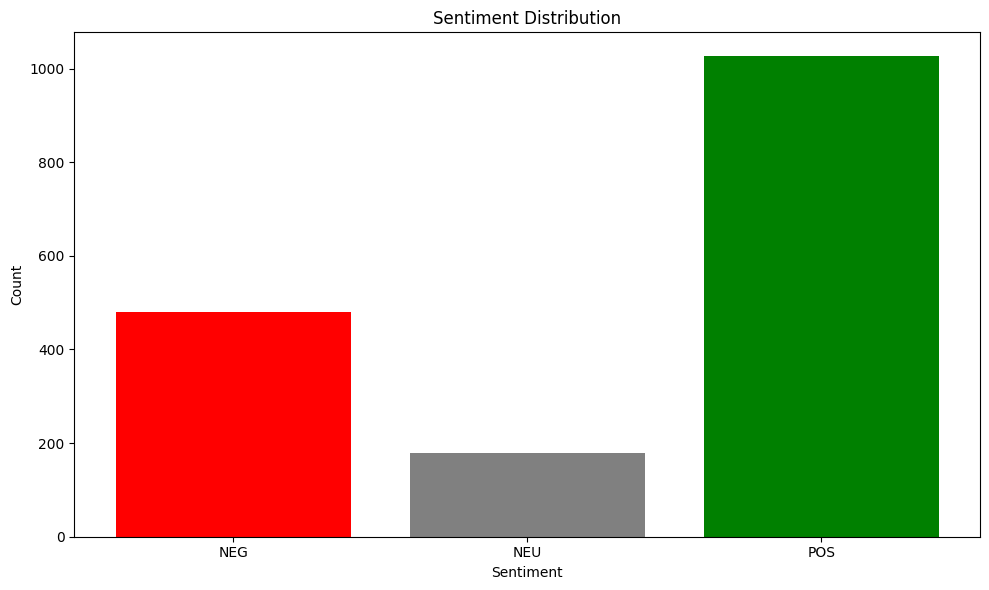

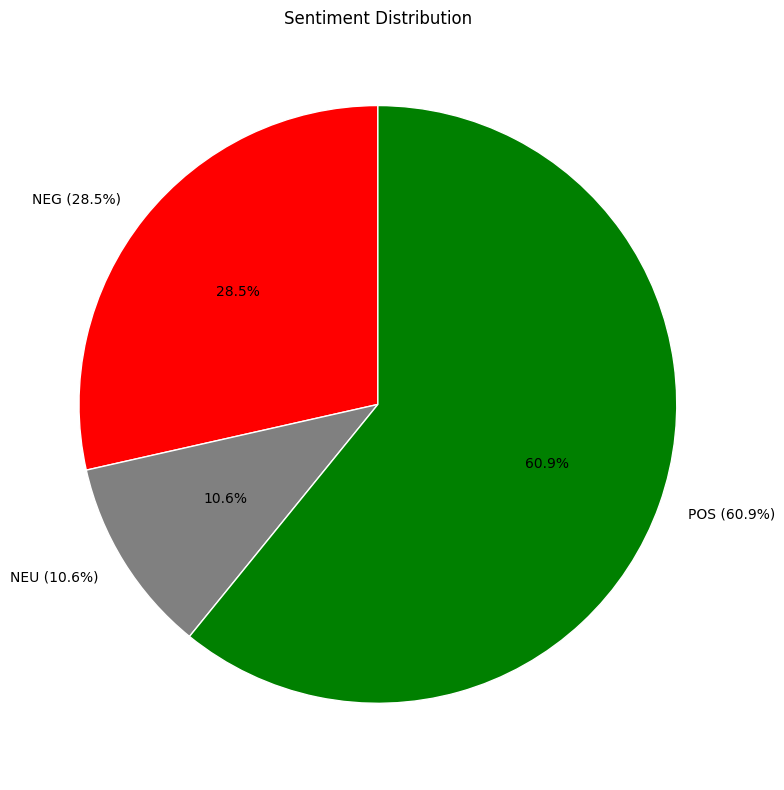

In [5]:
# Combine results into a single csv file
update_progress("Merging results", total_reviews, total_reviews, overall_start_time)
postprocess.merge_results_csv_in_hdfs(analysis_output_path, summary_output_path, "sentiment_analysis_full_results")

# Generate sentiment statistics
update_progress("Generating statistics", total_reviews, total_reviews, overall_start_time)
postprocess.generate_sentiment_statistics(sentiment_analysis_results_df, summary_output_path)

# Clean up temporary files
update_progress("Cleaning up", total_reviews, total_reviews, overall_start_time)

# Add explicit unpersist for cached DataFrames
reviews_df.unpersist()
sentiment_analysis_results_df.unpersist()
# Clear broadcasted variables when done
process.bc_tokenizer.unpersist()
process.bc_model.unpersist()

# Calculate overall metrics
overall_end_time = time.time()
total_duration = overall_end_time - overall_start_time

# Save final summary and metrics
save_final_summary(total_reviews, total_duration, process_duration)

2025-04-12 12:03:58,868 - INFO - Progress: Starting up
2025-04-12 12:03:58,870 - INFO - Progress can be monitored at: /tmp/sentiment_analysis_progress.txt
25/04/12 12:03:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
2025-04-12 12:03:58,885 - INFO - Progress: Loading data
2025-04-12 12:04:06,885 - INFO - Starting to handle all 1,686 reviews           
2025-04-12 12:04:06,888 - INFO - Progress: Data loaded - 0.0% (0/1686)
2025-04-12 12:04:06,891 - INFO - Progress: Loading model - 0.0% (0/1686)
2025-04-12 12:04:06,892 - INFO - Loading BERTweet model and tokenizer...
2025-04-12 12:04:09,917 - INFO - Broadcasting model and tokenizer to all workers
2025-04-12 12:04:14,007 - INFO - Progress: Repartitioning data - 0.0% (0/1686)
2025-04-12 12:04:14,009 - INFO - Repartitioning DataFrame for optimal processing...
2025-04-12 12:04:14,048 - INFO - Input file size: 8.54 MB
2025-04-12 12:04:14,053 - INFO - Repartitioning DataFrame into 16 par

In [4]:
logger.info("Generating sentiment analysis statistics...")

 # Count total reviews
total_count = sentiment_analysis_results_df.count()
logger.info(f"Total processed reviews: {total_count:,}")

2025-04-12 12:07:14,473 - INFO - Generating sentiment analysis statistics...
2025-04-12 12:07:14,793 - INFO - Total processed reviews: 1,686
